The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading tokenized reviews...
Loaded tokenized reviews: 0.0 s

Memorex Clock Radio for iPod
# reviews 6
3.3333333333333335  average stars

Reviews converted to sentences: 4.51 s
Exploded into row=sentence: 4.52 s
Tokenized sentences: 5.86 s
Analyzed sentiment: 6.22 s
Exploded into every token-sentence combo: 6.23 s
Created token-polarity subtables: 6.29 s
Merged polarity table: 6.3 s
Filled nulls: 8.43 s
Got a clean set of keywords: 8.43 s
Clustered keywords: 8.58 s

Original clusters
receive : return receive
duper : duper
easy : easier difficult intuitive easy
regular : regular
sound : surprisingly music powerful speakers sound
quality/deal : quality deal price
ipod/dock/charge : battery bedside ipod dock charge
size/super/extremely : surprisingly super compact space extremely fit size
week/minutes/time/ahead/product : time minutes prime product ahead amazon week day hour yesterday ready
sleep/annoy

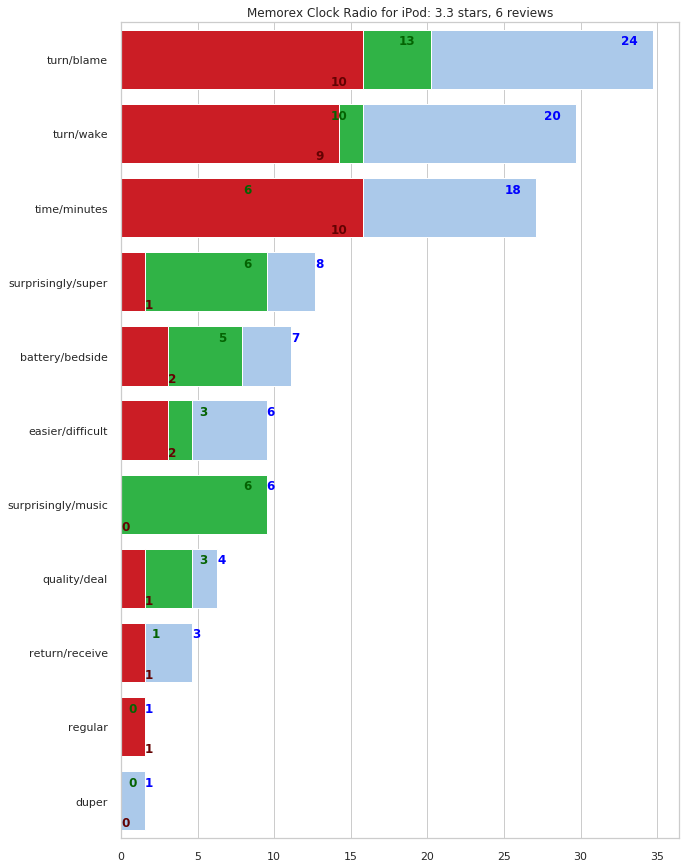

Runtime: 9.61 s

Done!!!


In [10]:
#IMPORTS
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import warnings
warnings.simplefilter('ignore')
from time import time
import numpy as np
import pandas as pd
import pickle
from gensim.models import Word2Vec
import spacy
nlp = spacy.load("en_core_web_sm")
from utils import (kw2counts, preprocess1, score_top_words, bar_plot, 
                    simple_clusters, pd_explode, sentiment)


flatten = lambda l: [item for sublist in l for item in sublist] #a clever way to flatten a list

# Load models
with open('models/bigrammer.pkl', mode='rb') as f:
    bigrammer = pickle.load(f)
w2v = Word2Vec.load('models/E_w2v_gensim10_2.model')


# PROGRAMMER INPUT: CHOOSING HYPERPARAMTERS FOR THIS PROGRAM:

#SENTIMENT - sentiment(sentence, stars, PNthresholds = [0.24,-0.15], star_importance=0.2)
PNthresholds = [0.24,-0.15]
star_importance=0.2
#FORMING CLUSTERS FROM KEYWORDS: simple_clusters(w2v, one_kws, choose = 30, cluster_size=6, merge=0.3)
initial_clusters = 30 # number of initial clusters(#keywords) to generate from
cluster_size = 6 #initial keyword qty of each cluster
merge = 0.33 #cluster similarity merging threshold
#CLUSTER SELECTION - score_top_words(cluster_polarity, PNTcols=['p_mentions','n_mentions','all_mentions'], 
#                                          PNTpriority=cluster_PNTpriority, n=num_output_clusters)
cluster_PNTpriority=(1.5, 2, 1, 1, 1) #cluster-importance scoring weights
num_output_clusters = 15
#CLUSTER NAMING - 
name_len = 2
words_PNTpriority = (1.5, 2, 1, 1, 1) #word-importance scoring weights for naming

#^^^^^^^^^^ PROGRAMMER INPUT ^^^^^^^^^^


# LOAD PREPROCESSED DATA
print('Loading tokenized reviews...')
t0 = time()
E_tokened = pd.read_json('data/Electronics_tokened_20to1000.json') #comment this out if you run repeatedly
print('Loaded tokenized reviews:', round(time()-t0,2),'s')


# GET 1000 RANDOM PRODUCTS
unique_products = [ID for ID in list(E_tokened.product_id.unique())]
product_id = str(np.random.choice(unique_products,size=1,replace=False)[0])

print()
t = time()
one = E_tokened[E_tokened.product_id==product_id] #GET REVIEWS FOR 1 PRODUCT
product_title = one.product_title.iloc[0]
print(product_title)
qty_reviews = one.shape[0]
ave_stars = one.stars.mean()
print('# reviews', qty_reviews)
print(ave_stars, ' average stars')
print()


# DROP product_id, product_title, IT'S ALL THE SAME
product_id = str(one.product_id.iloc[0]) #save for later
one.drop(['product_id','product_title'], axis=1, inplace=True)


#REVIEWS INTO SENTENCES
#uses spacy to parse sentences
parse_sentences = lambda x: [sent.text for sent in nlp(x).sents] 
one['sentences'] = one.review_body.apply(lambda x: parse_sentences(x))
print('Reviews converted to sentences:', round(time()-t,2),'s')


#EXPLODE INTO EACH ROW = EACH SENTENCE
one_sentences = pd_explode(one, 'sentences', 'sentence')
print('Exploded into row=sentence:', round(time()-t,2),'s')
one_sentences.head(2)


#TOKENIZE EACH SENTENCE 
sentence_preprocess = lambda row: list(set(bigrammer[preprocess1(row.sentence)]).intersection(set(row.tokened)))
one_sentences['sentence_tokens'] = one_sentences.apply(lambda row: sentence_preprocess(row), axis=1)
print('Tokenized sentences:', round(time()-t,2),'s')
one_sentences.head()


# DROP 'TOKENED', WE DON'T NEED IT ANYMORE 
one_sentences.drop('tokened',axis=1,inplace=True)


# SENTIMENT ANALYSIS
#----------->>> CAN GO BACK AND ADJUST POLARITY SCORE
# GET polarity of each sentence #let stars skew polarity
one_sentences['sentence_polarity'] = one_sentences.apply(lambda row: sentiment(row.sentence, row.stars,
                                                                    PNthresholds, star_importance), axis=1)
print('Analyzed sentiment:', round(time()-t,2),'s')


# ......toks_sentDF...........FIRST BIG DF TO KEEP AND COME BACK TO
# EXPLODE DATAFRAME INTO KEYWORD-SENTENCE PAIRS
tok_sentDF = pd_explode(one_sentences, 'sentence_tokens', 'token')
print('Exploded into every token-sentence combo:', round(time()-t,2),'s')


# CREATE WORD-LEVEL SENTIMENT POLARITY TABLE, Grouping by keyword
toksP = tok_sentDF[tok_sentDF['sentence_polarity']>0].groupby('token') \
                                        .agg({'review_id':list, 'sentence':list, 'stars':'count'})
toksP.rename(columns={'review_id':'p_reviews', 'sentence':'p_sentences', 
                       'stars':'p_mentions'}, inplace=True)

toksN = tok_sentDF[tok_sentDF['sentence_polarity']<0].groupby('token') \
                                        .agg({'review_id':list, 'sentence':list, 'stars':'count'})
toksN.rename(columns={'review_id':'n_reviews', 'sentence':'n_sentences', 
                         'stars':'n_mentions'}, inplace=True)

toksTOTAL = tok_sentDF.groupby('token').agg({'review_id':list, 'sentence':list, 'stars':'count'})
toksTOTAL.rename(columns={'review_id':'all_reviews','sentence':'all_sentences',
                          'stars':'all_mentions'}, inplace=True)
print('Created token-polarity subtables:', round(time()-t,2),'s')


# MERGE WORD-LEVEL SENTIMENT POLARITY TABLES
toks_polarity = pd.merge(toksP,toksN, how='outer', on='token')
toks_polarity = pd.merge(toks_polarity, toksTOTAL, how='outer', on='token')
toks_polarity = toks_polarity[['p_mentions','n_mentions','all_mentions','p_reviews','n_reviews','all_reviews',
                         'p_sentences','n_sentences','all_sentences']]
print('Merged polarity table:', round(time()-t,2),'s')


# FILL NULLS - missing #'s -> 0 missing lists of sentences/reviews -> []
toks_polarity[['p_mentions','n_mentions']] = toks_polarity[['p_mentions','n_mentions']].fillna(0)
toks_polarity[['p_reviews','n_reviews']] = toks_polarity[['p_reviews','n_reviews']].fillna('')
toks_polarity.p_reviews = toks_polarity.p_reviews.apply(lambda x: [] if x=='' else x)
toks_polarity.n_reviews = toks_polarity.n_reviews.apply(lambda x: [] if x=='' else x)

toks_polarity[['p_sentences','n_sentences']] = toks_polarity[['p_sentences','n_sentences']].fillna('')
toks_polarity.p_sentences = toks_polarity.p_sentences.apply(lambda x: [] if x=='' else x)
toks_polarity.n_sentences = toks_polarity.n_sentences.apply(lambda x: [] if x=='' else x)
print('Filled nulls:', round(time()-t,2),'s')
# ^^^^^ 2ND BIG DF TO REFERENCE


#GET KEYWORDS
one_kws = kw2counts(one.tokened)[:,0]
# ######ALTERNATIVE IDEA - but doesn't seem to work too well
#     one_kws = list(toks_polarity.index) #alternatively, build from toks_polarity
# ######ALTERNATIVE IDEA - but doesn't seem to work too well
# scored_toks,_ = score_top_words(toks_polarity, n=100*1000)
# one_kws = np.array(scored_toks.index)
print('Got a clean set of keywords:', round(time()-t,2),'s')


# GENERATE CLUSTERS FROM KEYWORDS
clusters = simple_clusters(w2v, one_kws, choose = initial_clusters, cluster_size=cluster_size, merge=merge)
print('Clustered keywords:', round(time()-t,2),'s')
print()
print('Original clusters')
for k, words in clusters.items():
    print(k,':',' '.join([word for word in words]))
print()


# GENERATE CLUSTER SENTIMENT POLARITY
cluster_polarity = pd.DataFrame()
for key, words in clusters.items():
    #aggregate all values of keywords in cluster
    cluster = toks_polarity[toks_polarity.index.isin(words)].sum()
    cluster_polarity = pd.concat([cluster_polarity, cluster.T], axis=1, sort=False)

cluster_polarity = cluster_polarity.transpose()
cluster_polarity['cluster_name'] = list(clusters.keys())
cluster_polarity.set_index('cluster_name', inplace=True)
print('Created cluster polarities:', round(time()-t,2),'s')


# REPRIORITIZE THE CLUSTERS - order clusters by selection priority
scored_clusters, _ = score_top_words(cluster_polarity, PNTcols=['p_mentions','n_mentions','all_mentions'], 
                                     PNTpriority=cluster_PNTpriority, n=num_output_clusters)
print('Prioritized clusters:', round(time()-t,2),'s')


# RENAME CLUSTERS - BASED ON MOST IMPORTANT TERMS
# ALTERNATIVE: I tried is grabbing the 2 words with most vector similarity to cluster words,
# but the results weren't as good
# ALTERNATIVE IDEA: TRY GRABBING THE FIRST 3 WORDS IN EACH AS A NAME
rename_dict = {}
for key, words in clusters.items():
    # SMART APPROACH - rename clusters by most important 2 words of each cluster
#             cluster_words = toks_polarity[toks_polarity.index.isin(words)]
#             cluster_words,_ = score_top_words(cluster_words, PNTcols=['p_mentions','n_mentions','all_mentions'],
#                                                 PNTpriority=words_PNTpriority)
#             new_cluster_name = '/'.join([word for word in cluster_words.index[:name_len]])
#             rename_dict[key] = new_cluster_name

        #SIMPLE APPROACH
        new_cluster_name = '/'.join([word for word in words[:name_len]])
        rename_dict[key] = new_cluster_name
scored_clusters.index = scored_clusters.reset_index().cluster_name.apply(lambda x: rename_dict[x])
print('Renamed clusters', round(time()-t,2),'s')
print('New cluster names:')
for old, new in rename_dict.items():
    print(old, ' | ', new)
print()


# METRIC - NUMBER OF CLUSTERS
total_topics = scored_clusters.shape[0]
print('Total Topics: ', total_topics)

# METRIC - TOTAL WORDS IN CLUSTERS
renamed_clusters = clusters.copy()
for old_name,new_name in rename_dict.items():
    renamed_clusters[new_name] = renamed_clusters.pop(old_name)
renamed_cluster = {key:words for key,words in renamed_clusters.items() if key in list(scored_clusters.index)}
cluster_vocab = list(set(flatten(
                    [words for name, words in renamed_clusters.items()])))
vocab_size = len(cluster_vocab)
print('Full cluster vocab: ', vocab_size)
print(np.array(cluster_vocab))

# METRIC - TOTAL REVIEWS COVERAGE
all_reviews = one.review_id.unique()
covered_reviews = list(set(flatten(scored_clusters.all_reviews)))
coverage_ratio = len(covered_reviews)/len(all_reviews)
print()
print('All reviews covered:', round(coverage_ratio*100,2),'%')

# METRIC - POLAR REVIEWS COVERAGE
all_polar_reviews = tok_sentDF[tok_sentDF.sentence_polarity!=0].review_id.unique()
covered_polar_reviews = list(set(flatten(scored_clusters.p_reviews + scored_clusters.n_reviews)))
polar_coverage_ratio = len(covered_polar_reviews)/len(all_polar_reviews)
print('Polar reviews covered:', round(polar_coverage_ratio*100,2),'%')

# METRIC - PREDICT NUMBER OF STARS BASED ON SENTIMENT
num_p = cluster_polarity.sum()['p_mentions']
num_n = cluster_polarity.sum()['n_mentions']
predicted_stars = (num_p*5 + num_n)/(num_p+num_n)
print('Actual stars: ', round(ave_stars,2))
print('Predicted stars: ', round(predicted_stars,2))

# METRIC - GENERATE A TABLE OF MISSED WORDS
all_covered_terms = list(set(flatten(list(clusters.values()))))
missed_words = toks_polarity[~toks_polarity.index.isin(all_covered_terms)][['p_mentions',
                                                                    'n_mentions','all_mentions']]

popular_missed = missed_words.sort_values('all_mentions', ascending=False) \
                      .reset_index().rename(columns={'token':'most_frequent'})[['most_frequent','all_mentions']]

positive_missed = missed_words.sort_values('p_mentions', ascending=False) \
                        .reset_index().rename(columns={'token':'most_positive'})[['most_positive','p_mentions']]

negative_missed = missed_words.sort_values('n_mentions', ascending=False) \
                        .reset_index().rename(columns={'token':'most_negative'})[['most_negative','n_mentions']]

missed_wordsDF = pd.concat([positive_missed,negative_missed, popular_missed,], axis=1)
print('Words that were missed:')
print(missed_wordsDF.head(7))


#     PLOT CLUSTERS & SAVE PLOT
bar_plot(scored_clusters, PNTcols=['p_mentions','n_mentions','all_mentions'],
         title = '{}: {} stars, {} reviews'.format(product_title[:100], round(ave_stars,1), qty_reviews),
         save='outputs/BARPLOTTEST.png')
runtime = time()-t
print('Runtime:', round(runtime,2),'s')

#     Create a pd.DataFrame of relevant facts about product 
oneDF = pd.DataFrame([[product_id, product_title, qty_reviews, ave_stars, predicted_stars, coverage_ratio, 
                      polar_coverage_ratio, total_topics, vocab_size, cluster_vocab, missed_wordsDF, clusters,
                     renamed_clusters, scored_clusters, runtime]], 
                    columns = ['product_id', 'product_title', 'review_count', 'ave_stars', 'predicted_stars', 
                               'coverage_ratio', 'polar_coverage_ratio', 'total_topics', 'vocab_size', 
                               'cluster_vocab', 'missed_wordsDF', 'original_clusters', 'renamed_clusters', 
                               'scored_clusters','runtime(s)'])
oneDF['toks_sents'] = [tok_sentDF]

print()
print('Done!!!')

# Some cool EDA on 1000 random products

In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
with open('/home/ubuntu/Opin-private/data/1000product_analysis.pkl', mode='rb') as f:
    onekproducts = pickle.load(f)

In [13]:
onekproducts['star_error'] = abs(onekproducts['ave_stars']-onekproducts['predicted_stars'])
onekproducts.describe()

,ave_stars,predicted_stars,coverage_ratio,polar_coverage_ratio,runtime(s),star_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.908280,3.980678,0.972826,0.964228,8.907964,0.252826
std,0.611039,0.693477,0.029490,0.033721,12.634974,0.196884
min,1.650000,1.590563,0.826923,0.800000,1.145943,0.000246
25%,3.560000,3.598693,0.957544,0.947368,2.839961,0.101587
50%,4.025387,4.128221,0.979592,0.968750,4.799235,0.209537
75%,4.382655,4.509154,1.000000,1.000000,9.693652,0.353504
max,5.000000,5.000000,1.000000,1.000000,166.337484,1.344988


Text(0.7, 33, 'std:0.197')

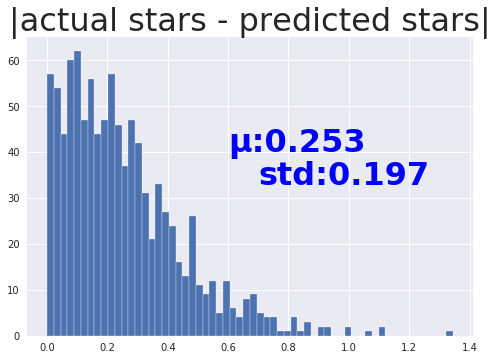

In [14]:
# Stars
plt.hist(onekproducts['star_error'], bins=60);
plt.title('|actual stars - predicted stars|', fontsize=32)
mean = round(np.mean(onekproducts['star_error']),3)
std = round(np.std(onekproducts['star_error']),3)
plt.text(.6,40,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(.7,33,'std:'+str(std), weight='bold', fontsize=32, color='blue')

Text(0.875, 30, 'std:2.9%')

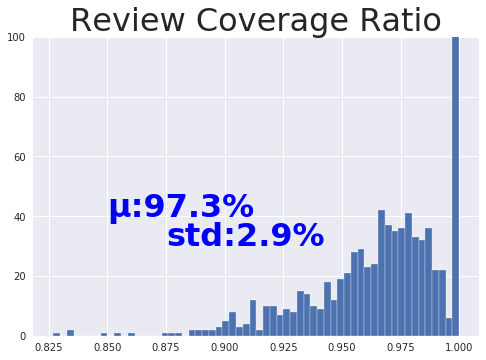

In [15]:
# Review Coverage
plt.hist(onekproducts['coverage_ratio'], bins=60);
plt.title('Review Coverage Ratio', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['coverage_ratio'])*100,1)
std = round(np.std(onekproducts['coverage_ratio'])*100,1)
plt.text(.85,40,'μ:'+str(mean)+'%', weight='bold', fontsize=32, color='blue')
plt.text(.875,30,'std:'+str(std)+'%', weight='bold', fontsize=32, color='blue')

Text(0.85, 30, 'std:3.4%')

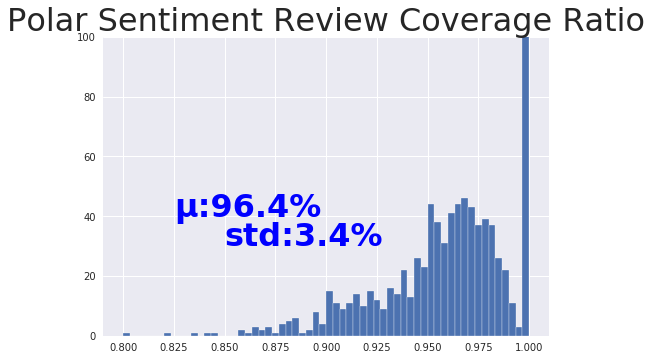

In [16]:
# Polar Review Coverage
plt.hist(onekproducts['polar_coverage_ratio'], bins=60);
plt.title('Polar Sentiment Review Coverage Ratio', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['polar_coverage_ratio'])*100,1)
std = round(np.std(onekproducts['polar_coverage_ratio'])*100,1)
plt.text(.825,40,'μ:'+str(mean)+'%', weight='bold', fontsize=32, color='blue')
plt.text(.85,30,'std:'+str(std)+'%', weight='bold', fontsize=32, color='blue')

Text(30, 30, 'std:12.63s')

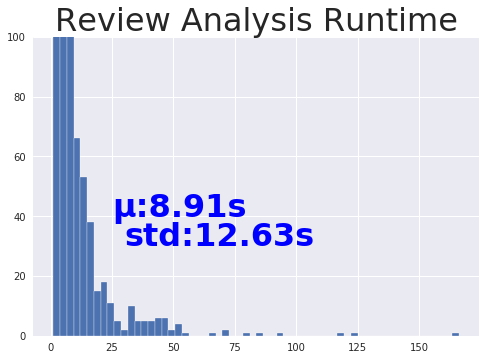

In [19]:
# Runtime
plt.hist(onekproducts['runtime(s)'], bins=60);
plt.title('Review Analysis Runtime', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts['runtime(s)']),2)
std = round(np.std(onekproducts['runtime(s)']),2)
plt.text(25,40,'μ:'+str(mean)+'s', weight='bold', fontsize=32, color='blue')
plt.text(30,30,'std:'+str(std)+'s', weight='bold', fontsize=32, color='blue')

Text(220, 30, 'std:116.1')

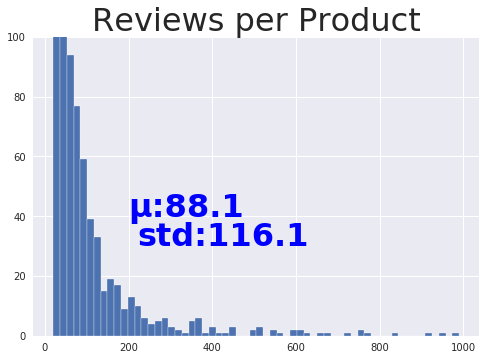

In [20]:
# Review Counts
plt.hist(onekproducts.review_count, bins=60);
plt.title('Reviews per Product', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.review_count),1)
std = round(np.std(onekproducts.review_count),1)
plt.text(200,40,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(220,30,'std:'+str(std), weight='bold', fontsize=32, color='blue')


Text(9, 45, 'std:1.5')

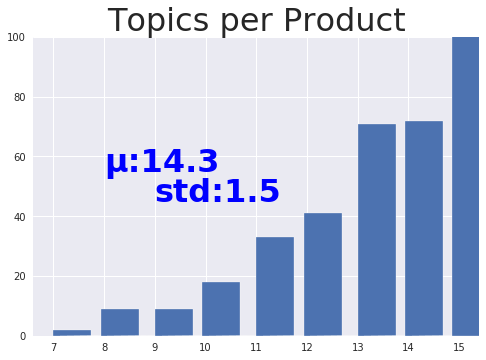

In [21]:
# Total topics

plt.hist(onekproducts.total_topics, bins=60, width=0.75);
plt.title('Topics per Product', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.total_topics),1)
std = round(np.std(onekproducts.total_topics),1)
plt.text(8,55,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(9,45,'std:'+str(std), weight='bold', fontsize=32, color='blue')

Text(110, 45, 'std:32.0')

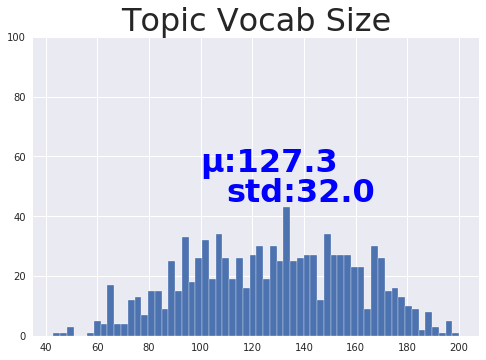

In [22]:
# TOTAL TOPIC VOCAB
plt.hist(onekproducts.vocab_size, bins=60);
plt.title('Topic Vocab Size', fontsize=32)
plt.ylim(0,100)
mean = round(np.mean(onekproducts.vocab_size),1)
std = round(np.std(onekproducts.vocab_size),1)
plt.text(100,55,'μ:'+str(mean), weight='bold', fontsize=32, color='blue')
plt.text(110,45,'std:'+str(std), weight='bold', fontsize=32, color='blue')

# Cluster Graphs

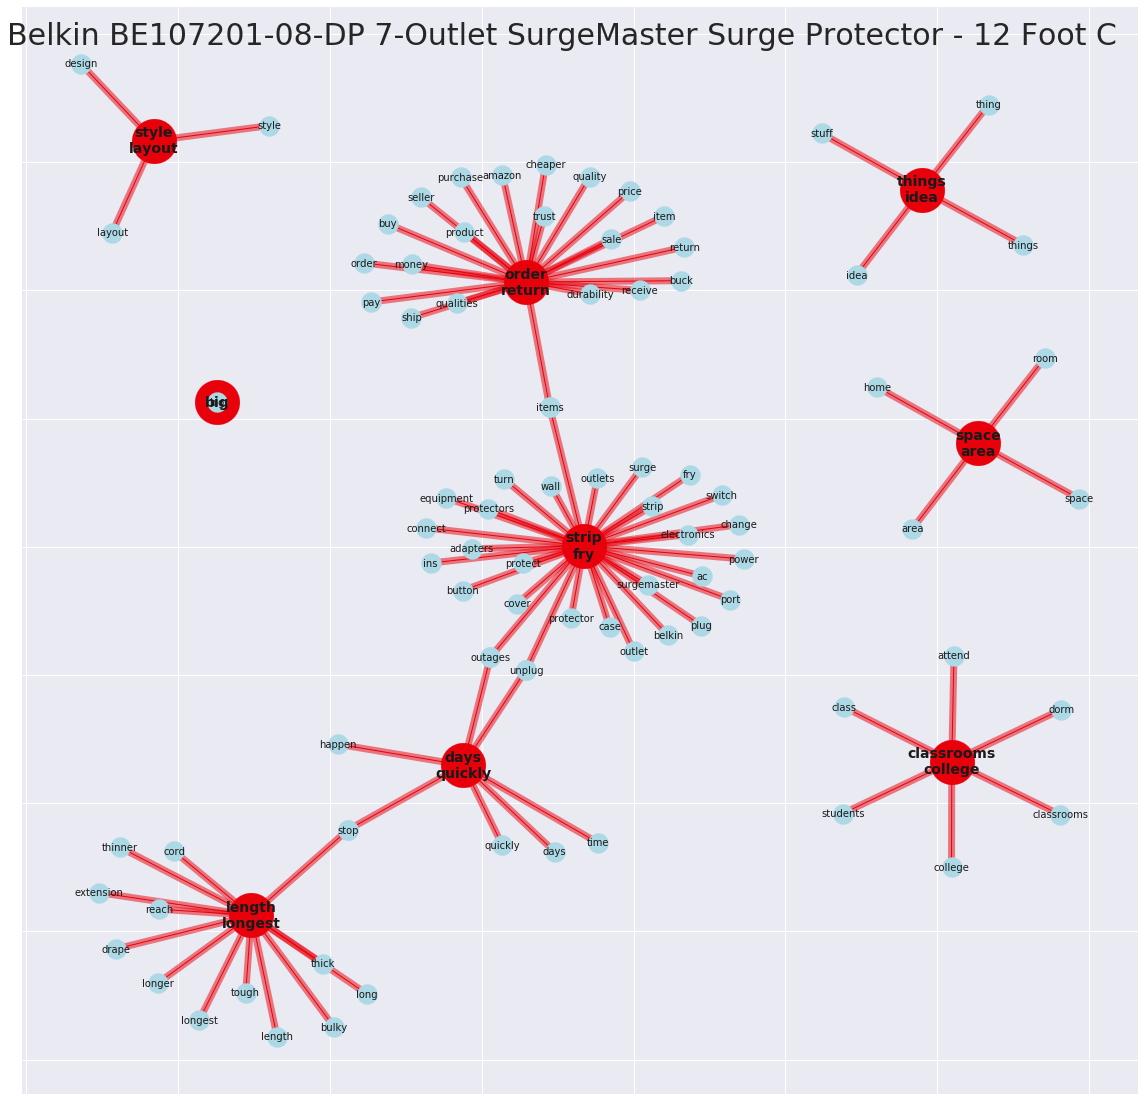

In [40]:
from utils import cluster_graph
random_product = onekproducts.sample()
clusters = random_product.renamed_clusters.iloc[0]
title = str(random_product.product_title.iloc[0][:70])
cluster_graph(clusters, title = title)

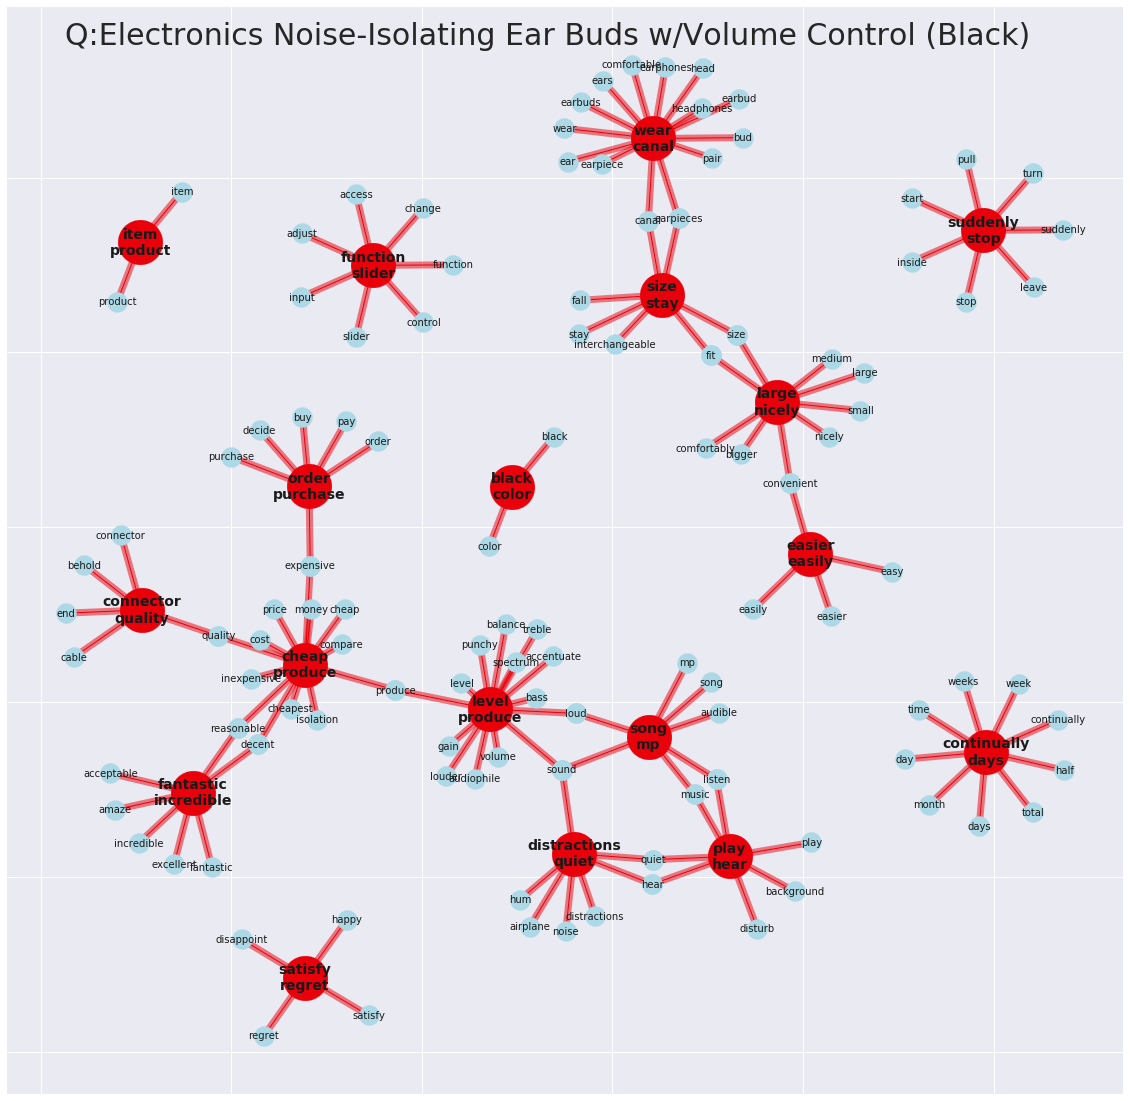

In [41]:
random_product = onekproducts.sample()
clusters = random_product.renamed_clusters.iloc[0]
title = str(random_product.product_title.iloc[0][:70])
cluster_graph(clusters, title = title)